1. To test the resource allocation, a small schedule is available in the file examples/schedulingexample.py

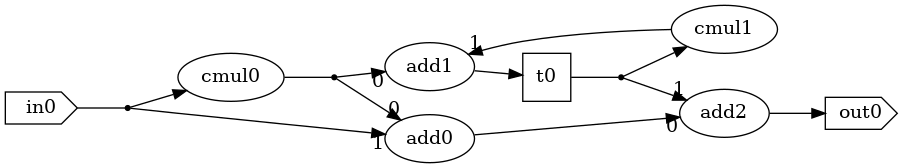

In [2]:
"""
====================================================
Example SFG used for scheduling in the TSTE87 course
====================================================

Node numbering from the original SFG used with the Matlab toolbox::

    sfg=addoperand([],'in',1,1);
    sfg=addoperand(sfg,'constmult',1,1,2,0.25);
    sfg=addoperand(sfg,'constmult',2,4,5,0.75);
    sfg=addoperand(sfg,'add',1,[2 1],6);
    sfg=addoperand(sfg,'add',2,[2 5],3);
    sfg=addoperand(sfg,'add',3,[6 4],7);
    sfg=addoperand(sfg,'delay',1,3,4);
    sfg=addoperand(sfg,'out',1,7);
"""
from b_asic.signal_flow_graph import SFG
from b_asic.special_operations import Delay, Input, Output

node1 = Input()
node2 = node1 * 0.25
node6 = node2 + node1
node4 = Delay()
node7 = node6 + node4
out = Output(node7)
node5 = 0.75 * node4
node3 = node2 + node5
node4 <<= node3

sfg = SFG([node1], [out], name="Scheduling example")
# %%
# The SFG looks like
sfg


a) Extract and print/plot the memory variables. 

/home/raswa151/courses/tste87/B-ASIC/b_asic/schedule.py:1153: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


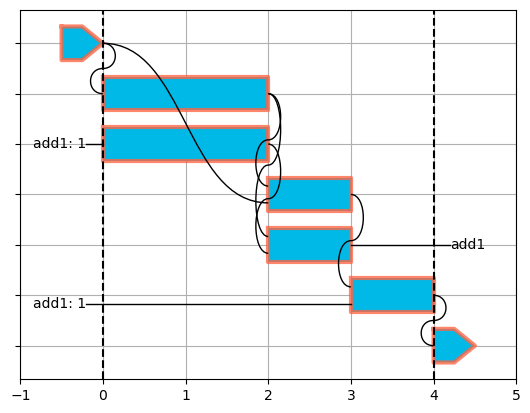

In [3]:
from b_asic.schedule import Schedule 
from b_asic.core_operations import Addition, ConstantMultiplication

sfg.set_latency_of_type(Addition.type_name(), 1)
sfg.set_execution_time_of_type(Addition.type_name(), 1)
sfg.set_latency_of_type(ConstantMultiplication.type_name(), 2)
sfg.set_execution_time_of_type(ConstantMultiplication.type_name(), 2)

schedule = Schedule(sfg, cyclic=True)
schedule.show()

/home/raswa151/courses/tste87/B-ASIC/b_asic/resources.py:734: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()  # type: ignore


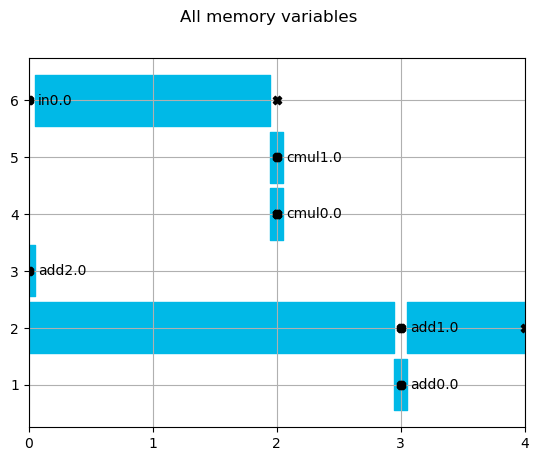

In [4]:
mem_vars_0 = schedule.get_memory_variables()
mem_vars_0.show(title="All memory variables")

b) Partition the memory variables using memories with one read port and one write port, assuming that it is possible to read and write concurrently. How many memories are required? How can the number of memories be reduced? 

In [5]:
mem_vars_set_0 = mem_vars_0.split_on_ports(read_ports=1, write_ports=1, total_ports=2)
mem_vars_set_1 = mem_vars_0.split_on_ports(read_ports=2, write_ports=1, total_ports=3)

print("Memories:\t\t", len(mem_vars_set_0))
print("One extra read port:\t",  len(mem_vars_set_1))

Memories:		 3
One extra read port:	 2


c) Apply the left edge algorithm to each memory. How many memory cells are required for each memory? 

/home/raswa151/courses/tste87/B-ASIC/b_asic/architecture.py:267: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()  # type: ignore


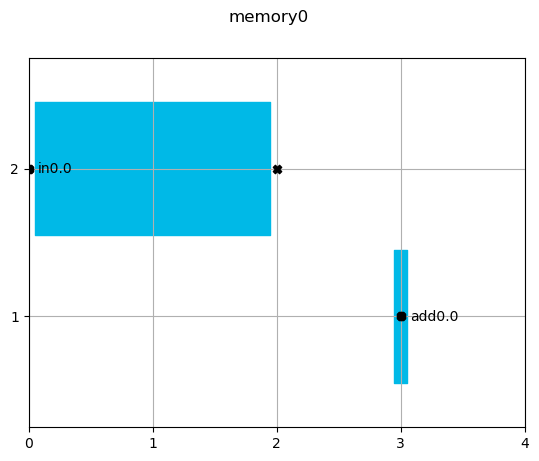

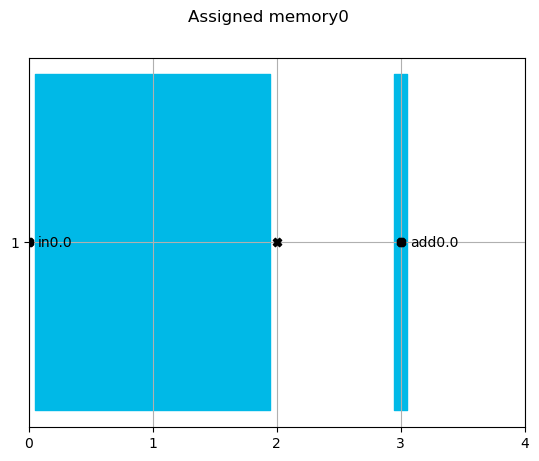

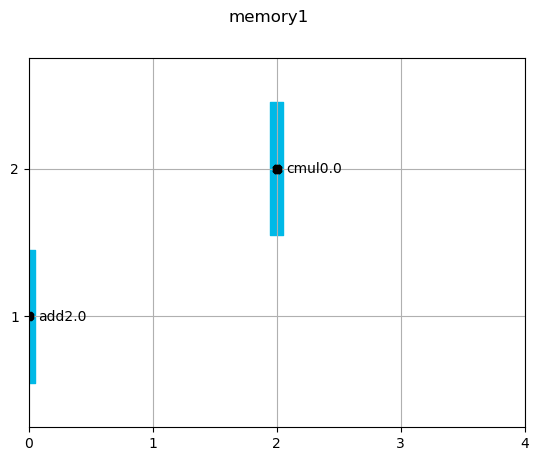

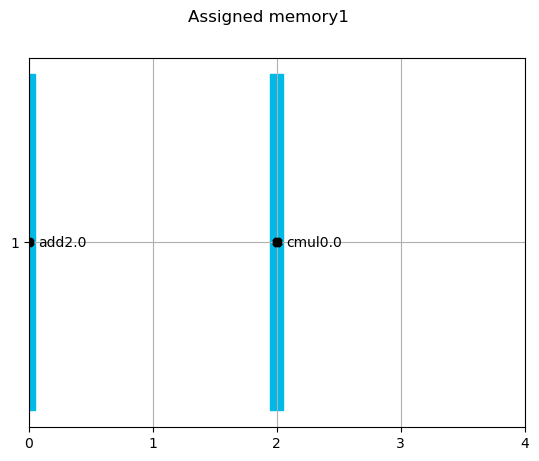

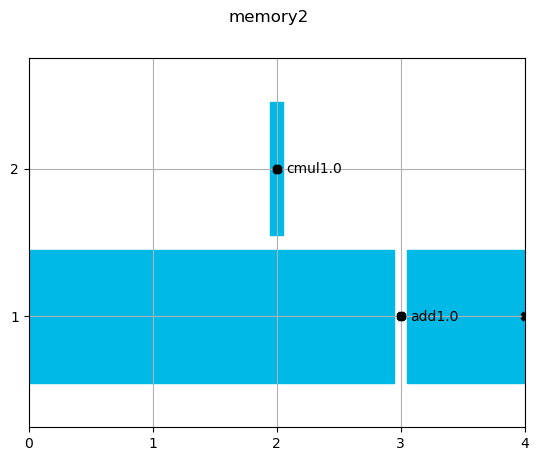

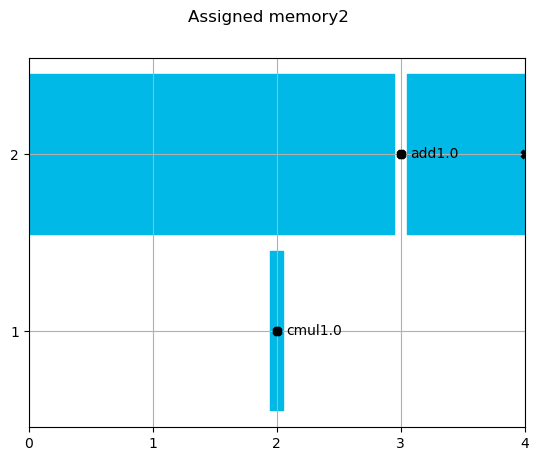

In [6]:
from b_asic.architecture import Memory

memories = []
for i, mem in enumerate(mem_vars_set_0):
    memory = Memory(mem, memory_type="RAM", entity_name=f"memory{i}")
    memories.append(memory)
    mem.show(title=f"{memory.entity_name}")
    memory.assign("left_edge")
    memory.show_content(title=f"Assigned {memory.entity_name}")

Answer:

One for first two, two for last?

d) Determine the number of adders and multipliers required. 

/home/raswa151/courses/tste87/B-ASIC/b_asic/schedule.py:1153: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


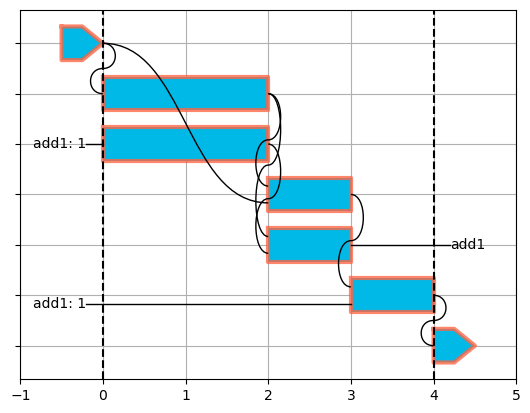

In [7]:
schedule.show()
#for mem in memories:
#    mem.show_content(title=f"Assigned {memory.entity_name}")

Answer:

According to schedule, 2 of each?  
If reading from the memories: two of each?

e) Assume that pipelining is introduced in the multipliers so that the execution time is halved. Change the execution time of the multipliers to one time unit. You can use set_exection_time_of_type on the Schedule.

/home/raswa151/courses/tste87/B-ASIC/b_asic/resources.py:734: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()  # type: ignore
/home/raswa151/courses/tste87/B-ASIC/b_asic/architecture.py:267: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()  # type: ignore


Memories:		 1


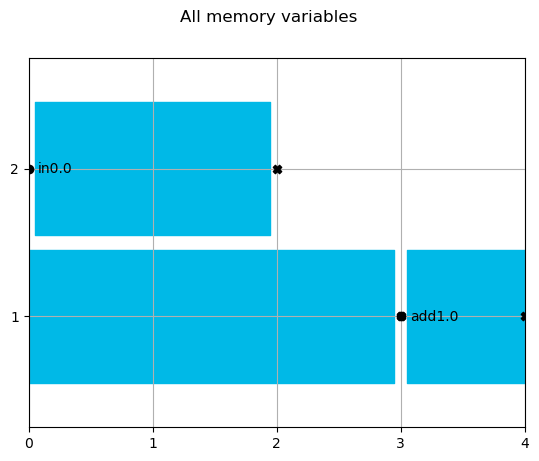

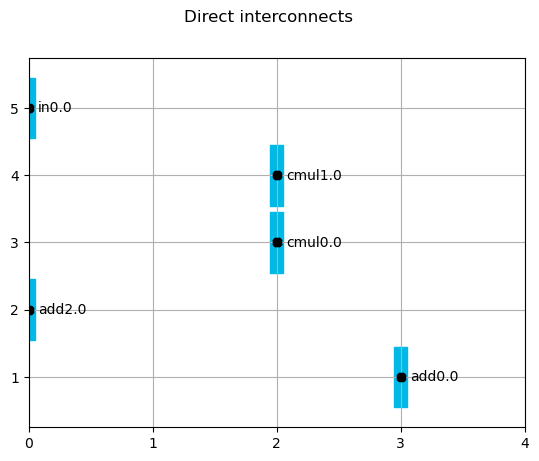

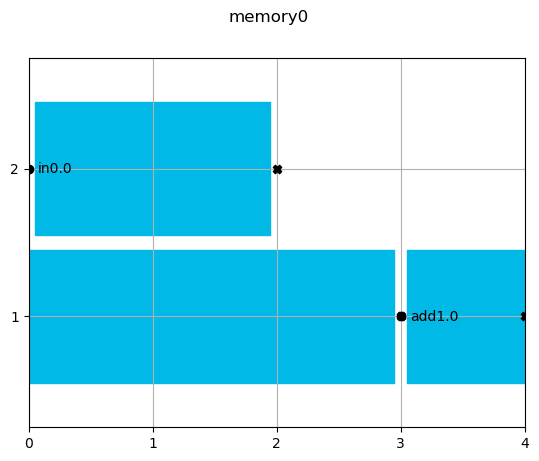

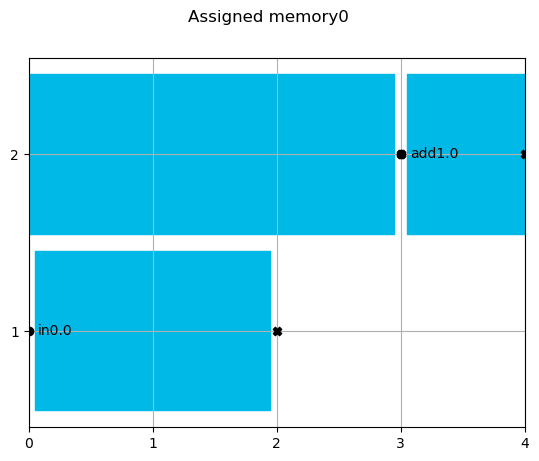

In [8]:
schedule.set_execution_time_of_type(ConstantMultiplication, 1)

mem_vars_2 = schedule.get_memory_variables()

direct, mem_vars_2 = mem_vars_2.split_on_length()
mem_vars_set_2 = mem_vars_2.split_on_ports(read_ports=1, write_ports=1, total_ports=2)

print("Memories:\t\t", len(mem_vars_set_2))

mem_vars_2.show(title="All memory variables")
direct.show(title="Direct interconnects")

memories = []
for i, mem in enumerate(mem_vars_set_2):
    memory = Memory(mem, memory_type="RAM", entity_name=f"memory{i}")
    memories.append(memory)
    mem.show(title=f"{memory.entity_name}")
    memory.assign("left_edge")
    memory.show_content(title=f"Assigned {memory.entity_name}")

f) Determine the number of adders and multipliers required. 

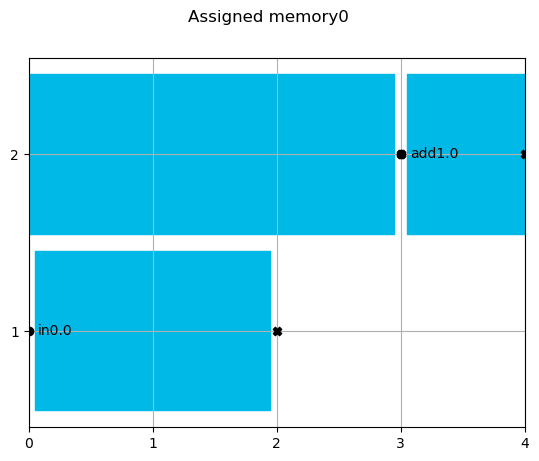

In [9]:
schedule.show()
for mem in memories:
    mem.show_content(title=f"Assigned {memory.entity_name}")

Answer:

Since schedule hasn't changed, no change?  
If looking at memories, something seems wrong?

g) Analyse the interconnect between the memories and processing elements and draw the architecture. 

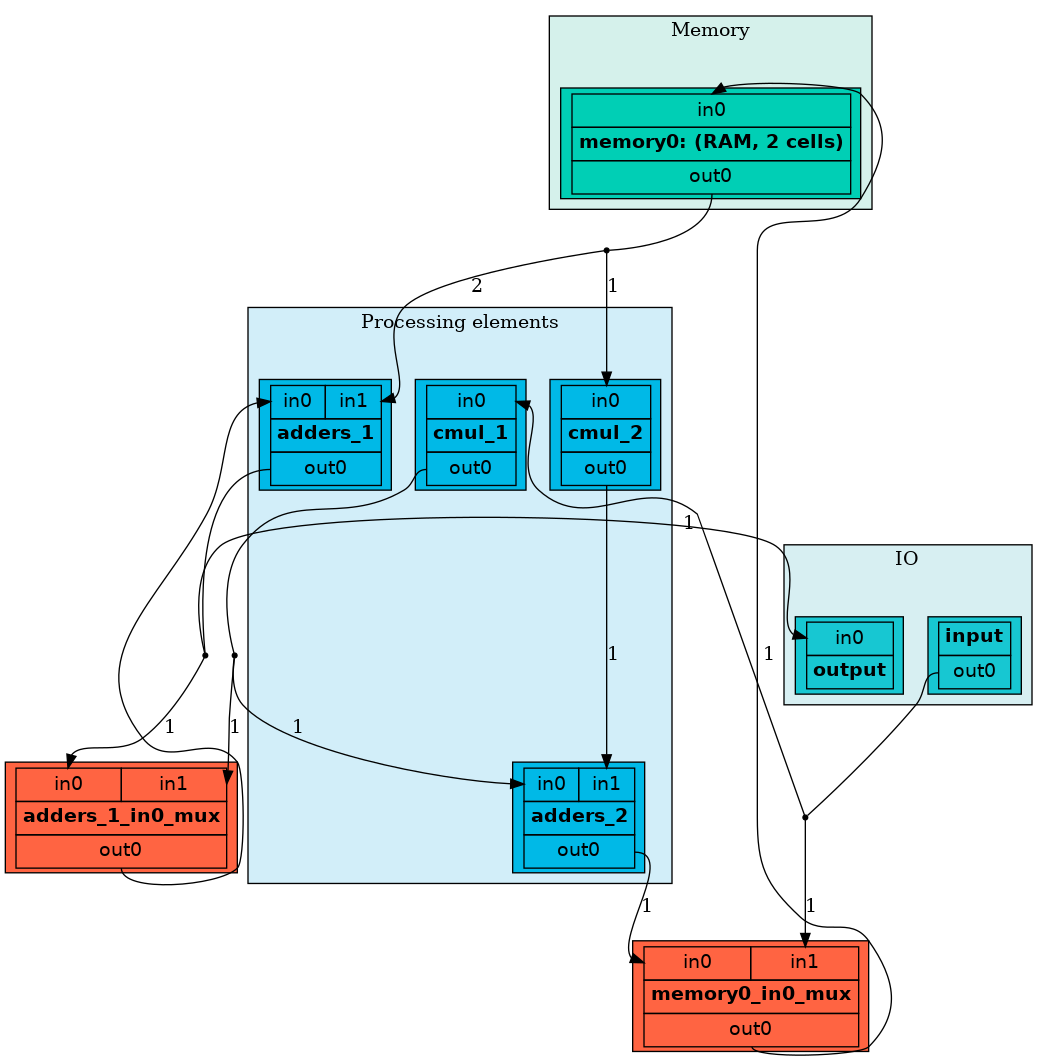

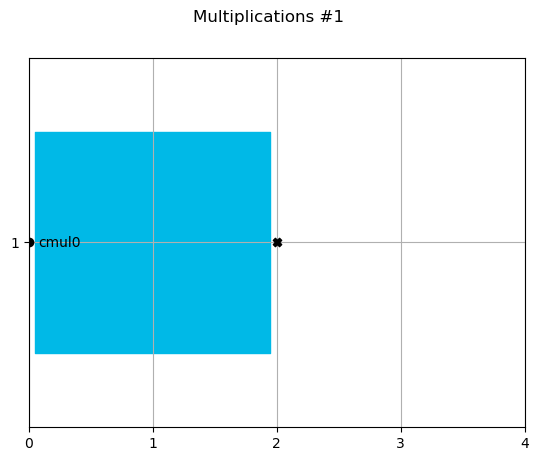

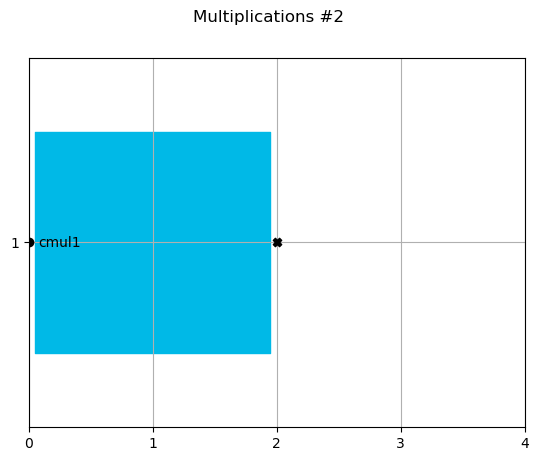

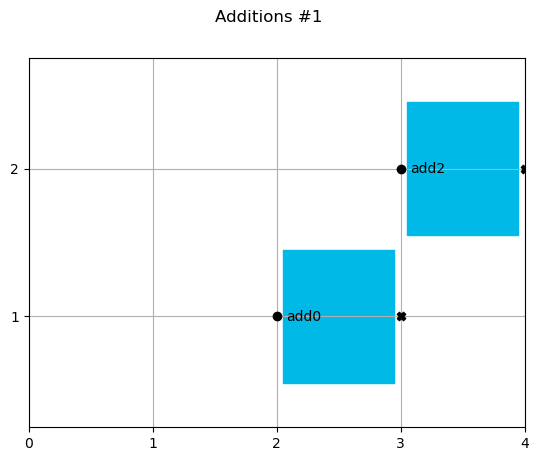

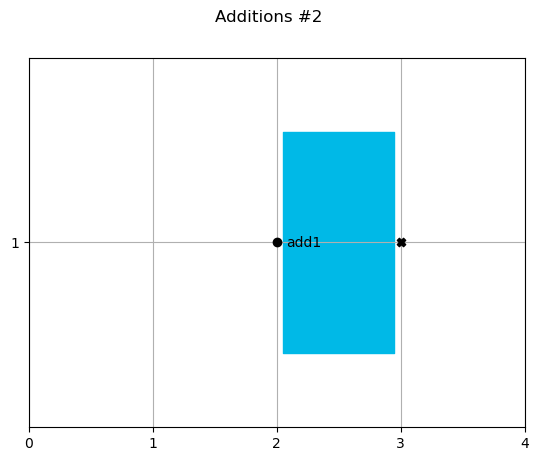

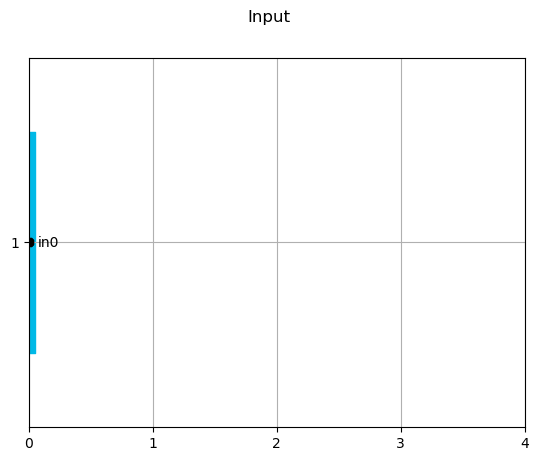

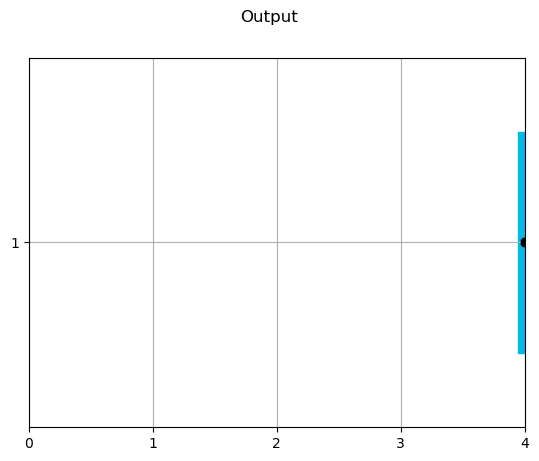

In [10]:
from b_asic.architecture import ProcessingElement
from b_asic.architecture import Architecture

ops = schedule.get_operations()
muls = ops.get_by_type_name("cmul").split_on_execution_time()
muls[0].show(title="Multiplications #1")
muls[1].show(title="Multiplications #2")
adds = ops.get_by_type_name("add").split_on_execution_time()
adds[0].show(title="Additions #1")
adds[1].show(title="Additions #2")
ins = ops.get_by_type_name("in")
ins.show(title="Input")
outs = ops.get_by_type_name("out")
outs.show(title="Output")

p1 = ProcessingElement(adds[0], entity_name="adders_1")
p2 = ProcessingElement(adds[1], entity_name="adders_2")
p3 = ProcessingElement(muls[0], entity_name="cmul_1")
p4 = ProcessingElement(muls[1], entity_name="cmul_2")
p_in = ProcessingElement(ins, entity_name="input")
p_out = ProcessingElement(outs, entity_name="output")

arch = Architecture({p1, p2, p3, p4, p_in, p_out}, memories, direct_interconnects=direct)
arch